In [165]:
from src.statespace import CAModel, StateSpace
from src.trajectory import Trajectory
from src.kalmanfilter import KalmanFilter

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

sns.set()

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
ndat = 100
q = 0.5
r = 50
init_state = np.array([0, 0, 1, -1, -0.1, 0.1])

cam = CAModel(q, r)
traj = Trajectory(cam, ndat, init_state, random_seed=564)

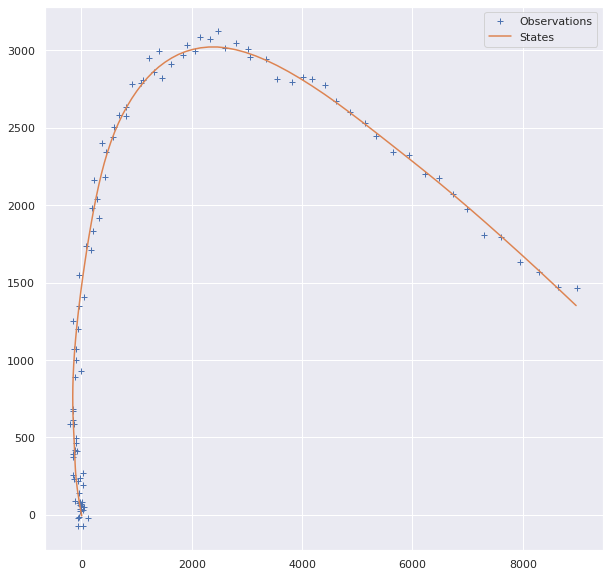

In [168]:
# Plot trajectory
plt.figure(figsize=(10, 10))
# plt.axis("equal")
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.legend()
plt.show()

In [169]:
kf_cam = KalmanFilter(cam)

for y in traj.observations:
    kf_cam.predict()
    kf_cam.update(y)
    

cam_hist = kf_cam.history

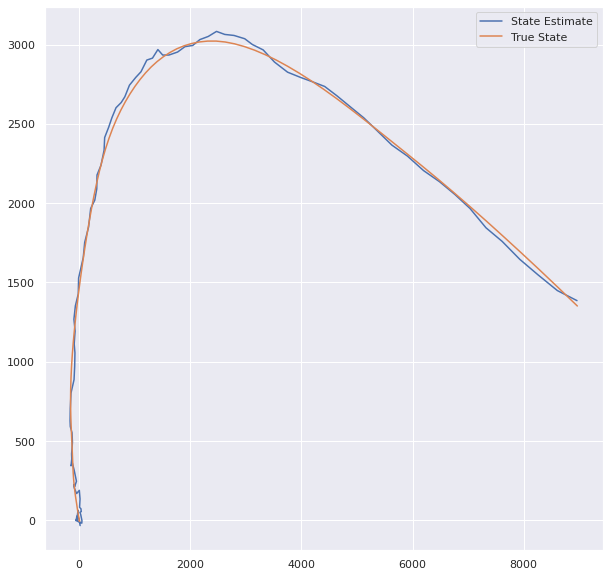

In [170]:
# Plot trajectory
plt.figure(figsize=(10, 10))
# plt.axis("equal")
# plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
plt.plot(cam_hist[:, 0], cam_hist[:, 1], label="State Estimate")
plt.plot(traj.X[:, 0], traj.X[:, 1], label="True State")

plt.legend()
plt.show()